

# Detecting Malicious URLs Using Machine Learning 

In [1]:
pip install tldextract

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 330.3 kB/s eta 0:05:02
   ---------------------------------------- 0.1/99.8 MB 656.4 kB/s eta 0:02:32
   ---------------------------------------- 0.1/99.8 MB 1.0 MB/s eta 0:01:37
   ---------------------------------------- 0.1/99.8 MB 1.0 MB/s eta 0:01:37
   ---------------------------------------- 0.2/99.8 MB 986.4 kB/s eta 0:01:41
   ---------------------------------------- 0.2/99.8 MB 986.4 kB/s eta 0:01:41
   ---------------------------------------- 0.3/99.8 MB 899.5 kB/s eta 0:01:51
   ---------------------------------------- 0.3/99.8 MB 899.5 kB/s eta 0:01:51
   ---------------------------------------- 0.6/99.8 MB 1.4 MB/s eta 0:01:12
   -----------------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tldextract
from urllib.parse import urlparse, unquote
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("malicious_phish.csv")

df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
df.shape

(651191, 2)

In [4]:
df.isnull().sum()

url     0
type    0
dtype: int64

In [7]:
type_counts = df["type"].value_counts()
type_counts

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

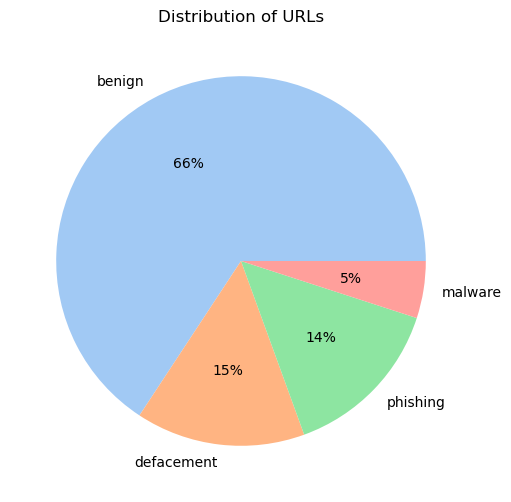

In [8]:
plt.figure(figsize=(6,6))
plt.pie(type_counts, labels=type_counts.index, colors=sns.color_palette("pastel"), autopct='%.0f%%')
plt.title("Distribution of URLs")
plt.show()

In [9]:
df["url"] = df["url"].str.replace("www.", "")

In [10]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [11]:
type_to_category = {
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
}

df["Category"] = df["type"].map(type_to_category)

In [12]:
df.head()

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [13]:
df["Url_length"] = df["url"].apply(len)

In [14]:
df.head()

,url,type,Category,Url_length
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


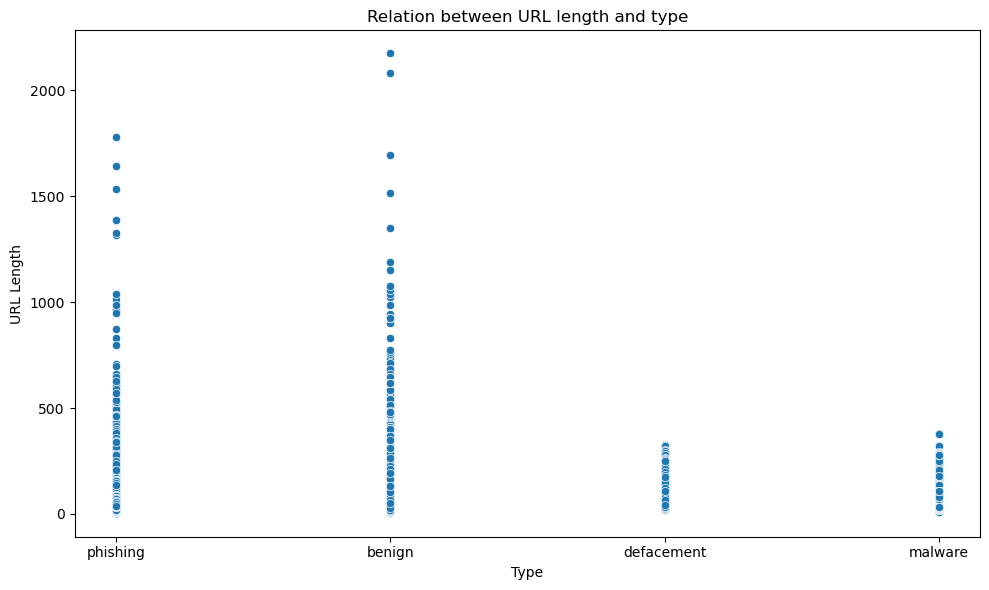

In [15]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="type", y="Url_length")
plt.title("Relation between URL length and type")
plt.xlabel("Type")
plt.ylabel("URL Length")
plt.tight_layout()
plt.show()

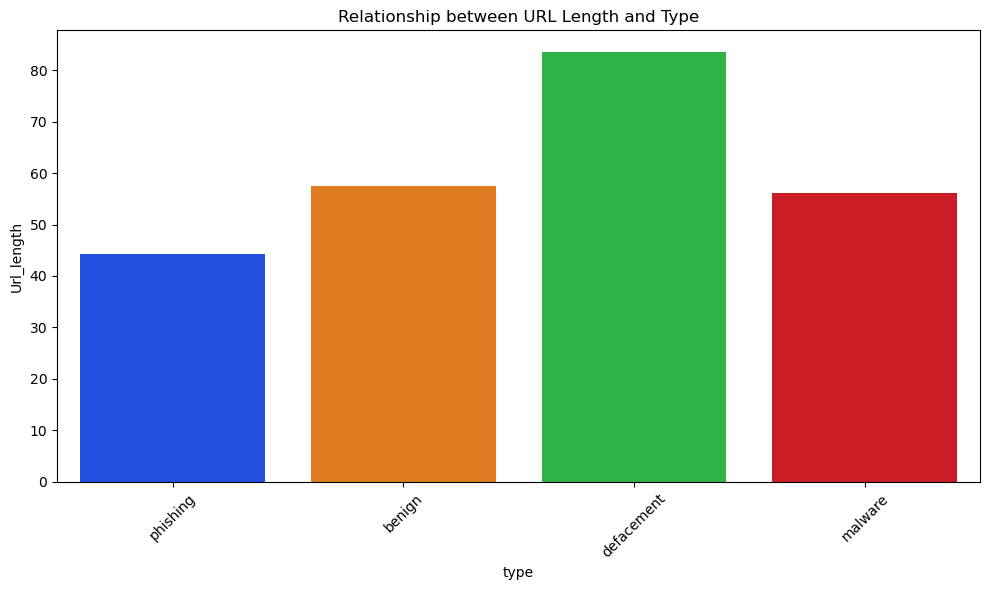

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='type', y='Url_length', palette="bright", errorbar=None)
plt.title("Relationship between URL Length and Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
df.head()

,url,type,Category,Url_length
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


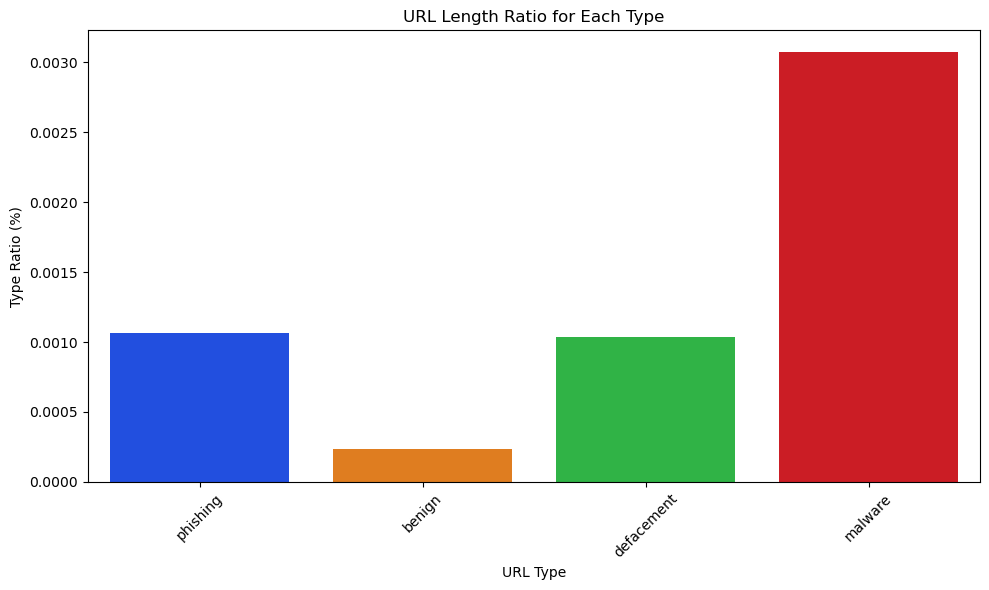

In [19]:
df["type_ratio"] = df.groupby("type")["Url_length"].transform(lambda x: x/x.sum()*100)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='type', y='type_ratio', errorbar=None, palette='bright')
plt.title("URL Length Ratio for Each Type")
plt.ylabel("Type Ratio (%)")
plt.xlabel("URL Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
df.head()

,url,type,Category,Url_length,type_ratio
0,br-icloud.com.br,phishing,2,16,0.000384
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916


In [21]:
def extract_domain(url):
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}"

df["domain"] = df["url"].apply(extract_domain)

In [22]:
df.head()

,url,type,Category,Url_length,type_ratio,domain
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net


In [23]:
characters_to_count = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']

def count_character_occurrences(url, character):
    return url.count(character)


for character in characters_to_count:
    df[f'{character}'] = df['url'].apply(lambda url: count_character_occurrences(url, character))

In [24]:
df.head()

,url,type,Category,Url_length,type_ratio,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [25]:
# Checking if Url have https
def has_https(url):
    return int("https" in url)

df['Has_HTTPS'] = df['url'].apply(has_https)

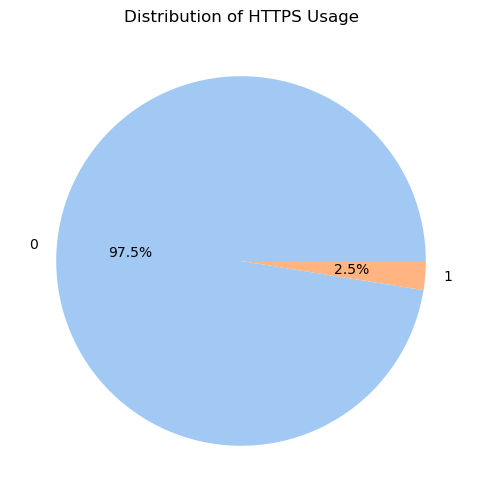

In [26]:
https_counts = df['Has_HTTPS'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(https_counts, labels=https_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Distribution of HTTPS Usage')
plt.show()

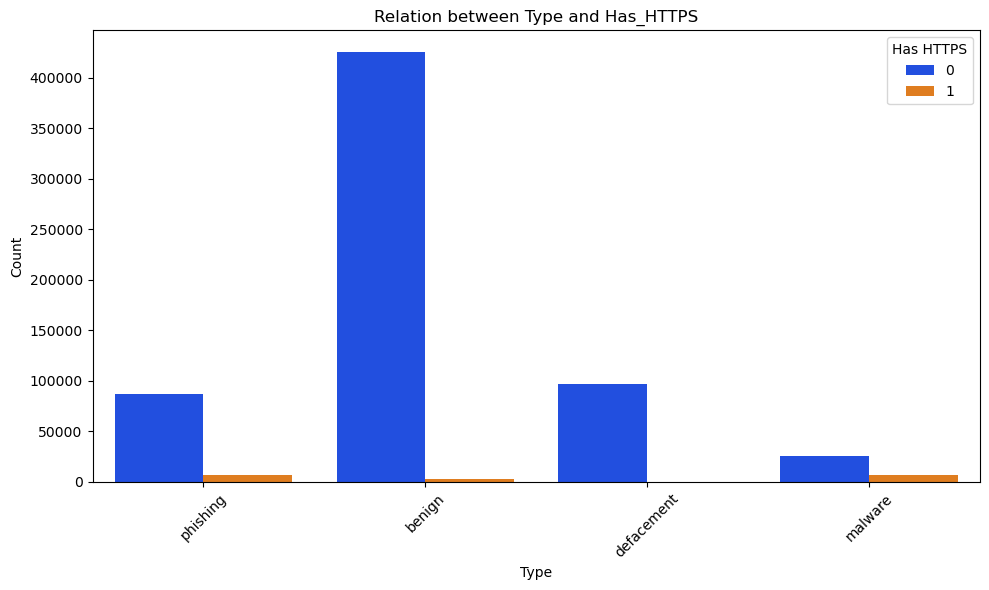

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', hue='Has_HTTPS',palette="bright")
plt.title("Relation between Type and Has_HTTPS")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has HTTPS")
plt.tight_layout()
plt.show()

In [28]:
def count_digits(string):
    return sum(1 for char in string if char.isdigit())

def count_letters(string):
    return sum(1 for char in string if char.isalpha())

df['Digit_Count'] = df['url'].apply(count_digits)
df['Letter_Count'] = df['url'].apply(count_letters)

In [29]:
df.head()

,url,type,Category,Url_length,type_ratio,domain,@,?,-,=,...,%,+,$,!,*,",",//,Has_HTTPS,Digit_Count,Letter_Count
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,0,0,0,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,0,0,0,1,0,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,0,0,0,1,0,22,199


In [30]:
shortening_pattern = r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' \
                     r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' \
                     r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' \
                     r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' \
                     r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' \
                     r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' \
                     r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' \
                     r'tr\.im|link\.zip\.net'


def has_shortening_service(url):
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)

df['Has_Shortening_Service'] = df['url'].apply(has_shortening_service)

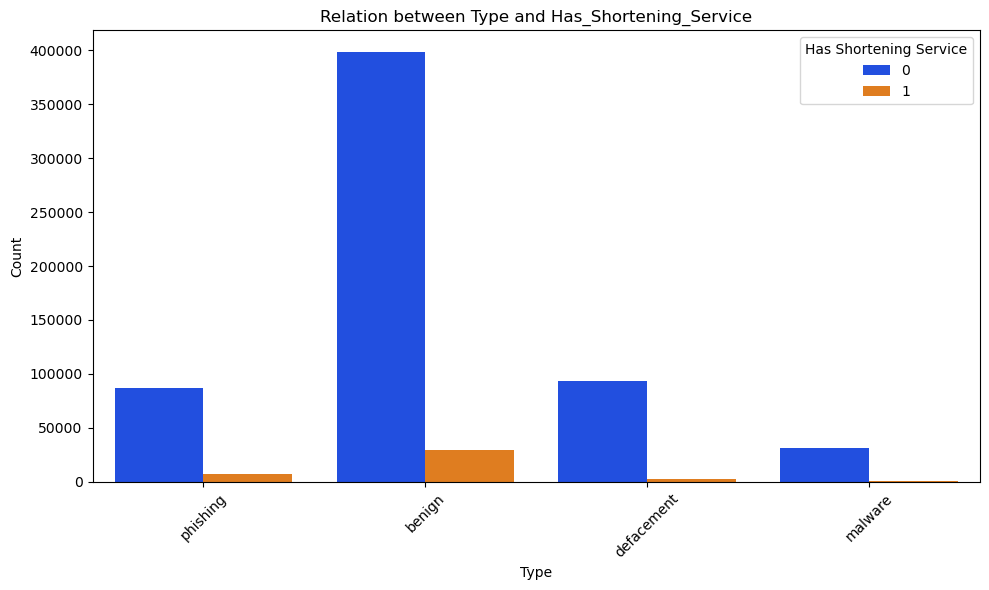

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', hue='Has_Shortening_Service',palette='bright')
plt.title("Relation between Type and Has_Shortening_Service")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has Shortening Service")
plt.tight_layout()
plt.show()

In [32]:
df.head()

,url,type,Category,Url_length,type_ratio,domain,@,?,-,=,...,+,$,!,*,",",//,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,0,0,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,0,0,1,0,22,199,0


In [33]:
ip_pattern = (
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
    r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'
    r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)'
    r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
    r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
    r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'
)


def has_ip_address(url):
    return int(re.search(ip_pattern, url, flags=re.I) is not None)

df['Has_IP_Address'] = df['url'].apply(has_ip_address)

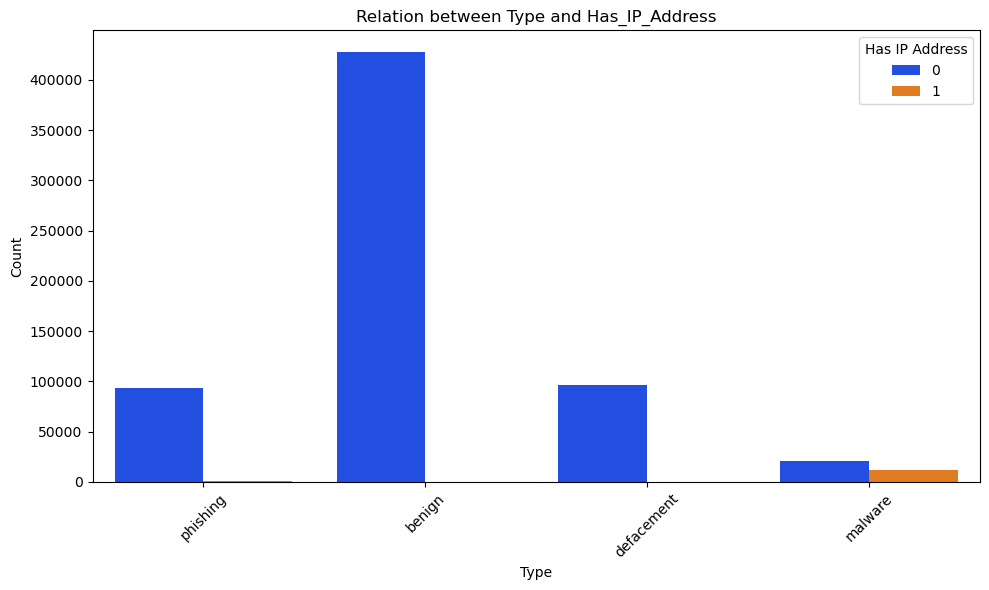

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', hue='Has_IP_Address',palette='bright')
plt.title("Relation between Type and Has_IP_Address")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has IP Address")
plt.tight_layout()
plt.show()

In [35]:
df.head()

,url,type,Category,Url_length,type_ratio,domain,@,?,-,=,...,$,!,*,",",//,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,0,1,25,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,0,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,0,1,0,22,199,0,0


In [38]:
def check_for_malicious_code(url):
    
    if re.search(r'javascript:', url):
        return 1
    
    if re.search(r'<\s*script', url, re.IGNORECASE) or re.search(r'on\w*=', url, re.IGNORECASE):
        return 1
    
    return 0


df['Has_javascript_Code'] = df['url'].apply(check_for_malicious_code)

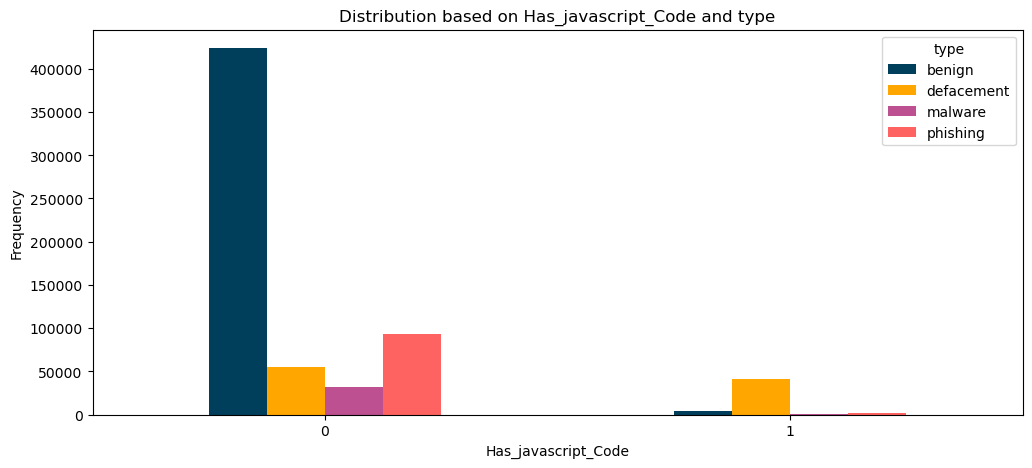

In [39]:
pd.crosstab(df["Has_javascript_Code"], df["type"]).plot(kind="bar", figsize=(12, 5),
                                                           color=['#003f5c', '#ffa600', '#bc5090', '#ff6361'])
plt.title('Distribution based on Has_javascript_Code and type')
plt.xlabel('Has_javascript_Code')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.legend(title="type")
plt.show()

In [40]:
df.head()

,url,type,Category,Url_length,type_ratio,domain,@,?,-,=,...,!,*,",",//,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address,Has_javascript_Code
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,0,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,0,1,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,0,1,25,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,0,1,0,7,60,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,0,1,0,22,199,0,0,1


In [41]:
def check_text_encoding(url):
    
    parsed_url = urlparse(url)

    text_part = parsed_url.path

    decoded_text = unquote(text_part)
    
    if decoded_text == text_part:
        return 0  
    else:
        return 1 

df['Has_Text_Encoding'] = df['url'].apply(check_text_encoding)

In [42]:
df.head()

,url,type,Category,Url_length,type_ratio,domain,@,?,-,=,...,*,",",//,Has_HTTPS,Digit_Count,Letter_Count,Has_Shortening_Service,Has_IP_Address,Has_javascript_Code,Has_Text_Encoding
0,br-icloud.com.br,phishing,2,16,0.000384,br-icloud.com.br,0,0,1,0,...,0,0,0,0,0,13,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0.000142,mp3raid.com,0,0,0,0,...,0,0,0,0,1,29,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0.000126,bopsecrets.org,0,0,0,0,...,0,0,0,0,1,25,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0.001042,garage-pirenne.be,0,1,1,4,...,0,0,1,0,7,60,0,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0.002916,adventure-nicaragua.net,0,1,1,3,...,0,0,1,0,22,199,0,0,1,0


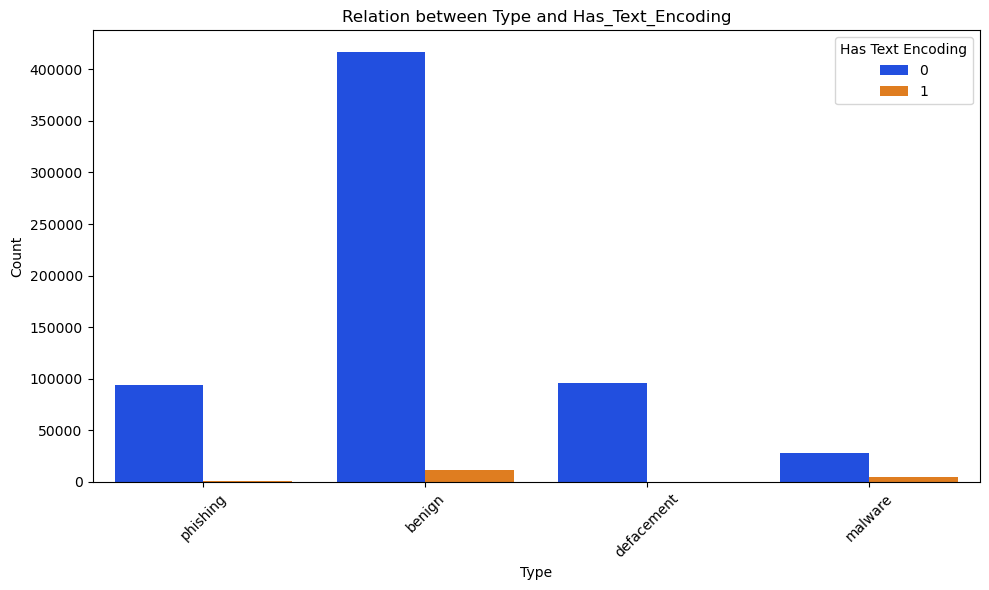

In [44]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type', hue='Has_Text_Encoding',palette='bright')
plt.title("Relation between Type and Has_Text_Encoding")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Has Text Encoding")
plt.tight_layout()
plt.show()

In [45]:
df.isnull().sum()

url                       0
type                      0
Category                  0
Url_length                0
type_ratio                0
domain                    0
@                         0
?                         0
-                         0
=                         0
.                         0
#                         0
%                         0
+                         0
$                         0
!                         0
*                         0
,                         0
//                        0
Has_HTTPS                 0
Digit_Count               0
Letter_Count              0
Has_Shortening_Service    0
Has_IP_Address            0
Has_javascript_Code       0
Has_Text_Encoding         0
dtype: int64

In [46]:
X = df.drop(['url','type','Category','domain','type_ratio','*'],axis=1)
y = df['Category']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (520952, 20)
X_test shape: (130239, 20)
y_train shape: (520952,)
y_test shape: (130239,)


In [48]:
df.columns

Index(['url', 'type', 'Category', 'Url_length', 'type_ratio', 'domain', '@',
       '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//',
       'Has_HTTPS', 'Digit_Count', 'Letter_Count', 'Has_Shortening_Service',
       'Has_IP_Address', 'Has_javascript_Code', 'Has_Text_Encoding'],
      dtype='object')

### XG Boost Classifier

In [49]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8883744500495243


### RandomForest Classifier

In [50]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.913343929237786


### AdaBoost Classifier

In [51]:
ada_classifier = AdaBoostClassifier(random_state=42)
ada_classifier.fit(X_train, y_train)

y_pred_ada = ada_classifier.predict(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
print("AdaBoost Accuracy:", accuracy_ada)

AdaBoost Accuracy: 0.4260167845269082


### SGD Classifier

In [52]:
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train)

y_pred_sgd = sgd_classifier.predict(X_test)

accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print("SGD Classifier Accuracy:", accuracy_sgd)

SGD Classifier Accuracy: 0.814725235912438


### ExtraTree Classifier

In [53]:
extra_trees_classifier = ExtraTreesClassifier(random_state=42)
extra_trees_classifier.fit(X_train, y_train)

y_pred_extra_trees = extra_trees_classifier.predict(X_test)

accuracy_extra_trees = accuracy_score(y_test, y_pred_extra_trees)
print("ExtraTrees Classifier Accuracy:", accuracy_extra_trees)

ExtraTrees Classifier Accuracy: 0.913221078171669


In [52]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy

In [53]:
model = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')])

# Output layer for binary classification
model.compile(loss=BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=2)


Epoch 1/2


260476/260476 [==============================] - 329s 1ms/step - loss: -2292659.0000 - accuracy: 0.5408
Epoch 2/2
260476/260476 [==============================] - 352s 1ms/step - loss: -35176652.0000 - accuracy: 0.5444


In [54]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

4070/4070 [==============================] - 4s 919us/step - loss: -75183768.0000 - accuracy: 0.5248
Test accuracy: 52.48%


In [57]:
new_url = "https://tricone-construction-inc.com/rse.merc/osci.php"

new_url_features = {
    'Url_length': len(new_url),
    '@': int('@' in new_url),
    '?': int('?' in new_url),
    '-': int('-' in new_url),
    '=': int('=' in new_url),
    '.': int('.' in new_url),
    '#': int('#' in new_url),
    '%': int('%' in new_url),
    '+': int('+' in new_url),
    '$': int('$' in new_url),
    '!': int('!' in new_url),
    ',': int(',' in new_url),
    '//': int('//' in new_url),
    'Has_HTTPS': int('https' in new_url),
    'Digit_Count': sum(c.isdigit() for c in new_url),
    'Letter_Count': sum(c.isalpha() for c in new_url),
    'Has_Shortening_Service': has_shortening_service(new_url),
    'Has_IP_Address': has_ip_address(new_url),
    'Has_javascript_Code': check_for_malicious_code(new_url),
    'Has_Text_Encoding': check_text_encoding(new_url)
}

new_url_df = pd.DataFrame([new_url_features])

prediction = clf.predict(new_url_df)

# Print the prediction
if prediction[0] == 0:
    print("The URL is predicted to be benign.")
elif prediction[0] == 1:
    print("The URL is predicted to be defacement.")
elif prediction[0] == 2:
    print("The URL is predicted to be phishing.")
elif prediction[0] == 3:
    print("The URL is predicted to be malware.")

The URL is predicted to be benign.
